In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from ipywidgets.widgets import interact
from IPython.display import display

%matplotlib notebook

In [2]:
columns = [
    "Regiocode",
    "Regionaam",
    "Inwoners",
    "Vermogen, vernieling en geweld",
    "Vermogensmisdrijven",
    "Diefstal",
    "Fietsendiefstal",
    "Diefstal overige vervoersmiddelen",
    "Diefstal uit of vanaf vervoermiddelen",
    "Zakkenrollerij, straatroof en beroving",
    "Woninginbraak (incl schuur, garage(box) en tuinhuis)",
    "Diefstal/inbraak uit niet-residentiele gebouwen",
    "Overige diefstal/inbraak",
    "Overige vermogensmisdrijven",
    "Vernielingen en misdrijven tegen openbare orde en gezag",
    "Vernielingen",
    "Vernieling aan auto",
    "Overige vernieling",
    "Misdrijven tegen openbare orde en gezag",
    "Gewelds- en seksuele misdrijven",
    "Mishandeling",
    "Bedreiging en stalking",
    "Overige gewelds- en seksuele misdrijven",
    "Totaal vermogen, vernieling en geweld (rel)",
    "Vermogensmisdrijven (rel)",
    "Diefstal/inbraak woning (rel)",
    "Vernieling en openbare orde (rel)",
    "Gewelds- en seksuele misdrijven (rel)"
    ]

In [3]:
cbs_crime = (
#    "https://www.cbs.nl/-/media/_excel/2016/45/"
    "Geregistreerde-criminaliteit-per-gemeente-wijk-en-buurt-2010-2015.xlsx"
)

In [4]:
def read_gemeente(shape_file, gemeente):
    df = gpd.read_file(shape_file)
    df = df[df['GM_NAAM'] == gemeente]
    df = df.where(df > -9999999., gpd.np.NaN)
    df['coords'] = df['geometry'].apply(
        lambda x: x.representative_point().coords[:][0])
    df['Regiocode'] = df['BU_CODE']
    df.set_index(['GM_CODE', 'WK_CODE', 'BU_CODE'], inplace=True)
    return df


def mk_feature_plot(dframe, **kwargs):
    new_kwargs = dict(
        cmap='OrRd',
        linewidth=0.2,
        label=False
    )
    new_kwargs.update(kwargs)

    def do_plot(feature):
        ax = dframe.plot(column=feature, **new_kwargs)
        ax.set_xticks([])
        ax.set_yticks([])

        if new_kwargs['label']:
            for idx, row in dframe.iterrows():
                plt.annotate(s=row[feature], xy=row['coords'],
                             horizontalalignment='center', fontsize=6)
    return do_plot

def read_crime(year):
    sheetnames = {
        2010:'Tabel 1',
        2011:'Tabel 2',
        2012:'Tabel 3',
        2013:'Tabel 4',
        2014:'Tabel 5',
        2015:'Tabel 6'
        }
    try:
        sheet = sheetnames[int(year)]
    except KeyError:
        raise Exception("No crime data for the year {} available".format(year))
        
    crime_df = pd.read_excel(cbs_crime, sheetname=sheet,
        header=None, names=columns, skiprows=6, na_values=".")
    # crime_df.fillna(0, inplace=True)
    return crime_df

In [5]:
nijmegen = read_gemeente('buurten', 'Nijmegen')

In [6]:
crime_2015 = read_crime(2015)

In [7]:
nijmegen_crime_2015 = nijmegen.merge(crime_2015, on='Regiocode')

<IPython.core.display.Javascript object>


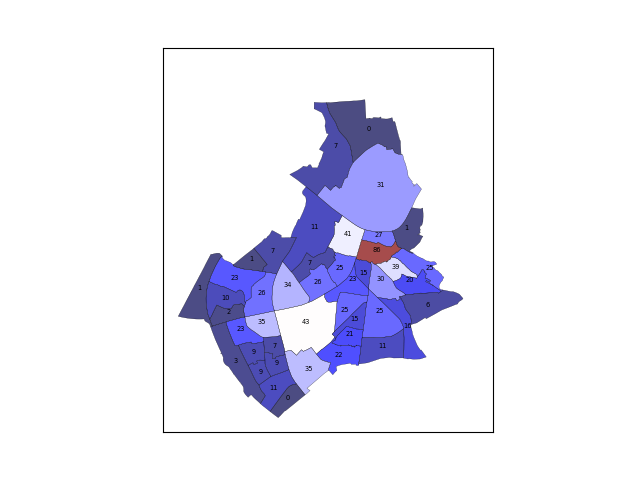

In [8]:
interact(
    mk_feature_plot(nijmegen_crime_2015, alpha=0.7,
                    label=True, cmap='seismic'),
    feature=list(nijmegen_crime_2015.columns))

In [14]:
amsterdam = read_gemeente('buurten', 'Amsterdam')

In [15]:
amsterdam_crime_2015 = amsterdam.merge(crime_2015, on='Regiocode')

<IPython.core.display.Javascript object>


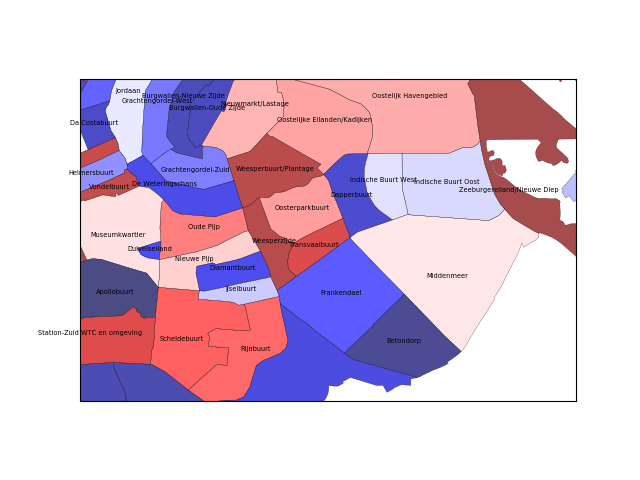

In [16]:
interact(mk_feature_plot(amsterdam_crime_2015, label=True,
                         alpha=0.7, cmap='seismic'),
        feature=list(amsterdam_crime_2015.columns));